# NASA Data Collection and Analysis

Este caderno Jupyter é destinado à coleta e análise de dados da NASA, incluindo asteroides, a Imagem do Dia (APOD) e fotos do Rover Curiosity. O código está estruturado em classes para facilitar a manutenção e a leitura.

In [15]:
# Importando bibliotecas necessárias
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any


## Classe NASAColetorDados

Esta classe é responsável por buscar dados da NASA, como asteroides, APOD e fotos do Mars Rover.


In [16]:
class NASAColetorDados:
    """Classe para buscar dados da NASA, como asteroides, APOD e fotos do Mars Rover."""
    
    def __init__(self, chave_api: str = 'dgPFFncGWYee3CsXdymc6IGxwXoTD2bMMbRMgA2d'):
        self.chave_api = chave_api

    def buscar_dados_asteroides(self, data_inicio: str, data_fim: str) -> List[Dict[str, Any]]:
        """Busca dados de asteroides em um intervalo de datas."""
        url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={data_inicio}&end_date={data_fim}&api_key={self.chave_api}'
        resposta = requests.get(url)
        if resposta.status_code == 200:
            dados = resposta.json()
            lista_asteroides = [
                {
                    'Nome': ast['name'], 
                    'ID': ast['id'], 
                    'Data Aproximação': data,
                    'Diâmetro Mínimo (km)': ast['estimated_diameter']['kilometers']['estimated_diameter_min'],
                    'Diâmetro Máximo (km)': ast['estimated_diameter']['kilometers']['estimated_diameter_max'],
                    'Velocidade Relativa (km/s)': ast['close_approach_data'][0]['relative_velocity']['kilometers_per_second'],
                    'Distância Passagem (km)': ast['close_approach_data'][0]['miss_distance']['kilometers'],
                    'Perigoso': ast['is_potentially_hazardous_asteroid'],
                    'Data Observação': ast.get('orbital_data', {}).get('first_observation_date', 'N/A')
                } for data, asteroides in dados['near_earth_objects'].items() for ast in asteroides
            ]
            return lista_asteroides
        print(f"Erro: {resposta.status_code}")
        return []

    def buscar_imagem_dia(self, data_inicio: str, data_fim: str) -> List[Dict[str, Any]]:
        """Busca a imagem do dia da NASA (APOD) em um intervalo de datas."""
        url = 'https://api.nasa.gov/planetary/apod'
        params = {'start_date': data_inicio, 'end_date': data_fim, 'api_key': self.chave_api}
        resposta = requests.get(url, params=params)
        if resposta.status_code == 200:
            return resposta.json()
        print(f"Erro: {resposta.status_code}")
        return []

    def contar_fotos_mars_rover(self, ano: int, mes: str, dia: str) -> int:
        """Conta quantas fotos o Rover Curiosity tirou em uma data específica."""
        url = f"https://api.nasa.gov/mars-photos/api/v1/rovers/curiosity/photos?earth_date={ano}-{mes}-{dia}&api_key={self.chave_api}"
        resposta = requests.get(url)
        if resposta.status_code == 200:
            dados = resposta.json()
            fotos = dados.get('photos', [])
            return len(fotos)
        print(f"Erro: {resposta.status_code}")
        return 0


## Classe AnalisadorDados

Esta classe é responsável por analisar e visualizar os dados coletados.


In [17]:
class AnalisadorDados:
    """Classe para analisar e visualizar dados de asteroides, APOD e fotos do Mars Rover."""
    
    def __init__(self, coletor: NASAColetorDados, dados_asteroides_2005: pd.DataFrame, dados_asteroides_2024: pd.DataFrame, apod_data: List[List[Dict[str, Any]]]):
        self.coletor = coletor
        self.dados_asteroides = pd.concat([dados_asteroides_2005.assign(Ano=2005), dados_asteroides_2024.assign(Ano=2024)])
        self.apod_data = apod_data

    def exibir_imagemdia_detalhes(self) -> None:
        """Exibe detalhes das entradas do APOD."""
        intervalos = ['2024-09-01 a 2024-09-07', '2005-09-01 a 2005-09-07']
        for i, apod in enumerate(self.apod_data):
            print(f"APOD de {intervalos[i]}:")
            for item in apod:
                print(f"Título: {item['title']}")
                print(f"Data: {item['date']}")
                print(f"URL: {item['url']}")
                print(f"Explicação: {item['explanation']}\n")

    def plotar_dados_asteroides(self) -> None:
        """Plota gráficos sobre asteroides e se são perigosos ou não."""
        plt.figure(figsize=(12, 5))

        # Gráfico do número total de asteroides
        plt.subplot(1, 2, 1)
        contagem_asteroides = self.dados_asteroides.groupby('Ano')['ID'].count().reset_index()
        sns.barplot(x='Ano', y='ID', data=contagem_asteroides)
        plt.title('Número de Asteroides Detectados')

        # Gráfico de asteroides potencialmente perigosos
        plt.subplot(1, 2, 2)
        perigosos = self.dados_asteroides.groupby(['Ano', 'Perigoso'])['ID'].count().unstack().reset_index()
        perigosos.plot(kind='bar', stacked=True, x='Ano', ax=plt.gca())
        plt.title('Asteroides Potencialmente Perigosos')
        plt.show()

    def plotar_apod(self) -> None:
        """Plota a quantidade de entradas do APOD por intervalo de datas."""
        intervalos = ['2024-09-01 a 2024-09-07', '2005-09-01 a 2005-09-07']
        contagem_apod = [len(apod) for apod in self.apod_data]
        plt.bar(intervalos, contagem_apod, color=['blue', 'orange'])
        plt.xlabel('Intervalos de Data')
        plt.ylabel('Número de Entradas APOD')
        plt.title('Comparação de Entradas APOD')
        plt.show()

    def plotar_fotos_mars_rover(self, dia: str, mes: str) -> None:
        """Plota quantas fotos o Rover Curiosity tirou em datas específicas."""
        contagem_fotos = [self.coletor.contar_fotos_mars_rover(ano, mes, dia) for ano in [2015, 2023]]
        anos = ['2015', '2023']
        plt.bar(anos, contagem_fotos, color=['blue', 'orange'])
        plt.xlabel('Ano')
        plt.ylabel('Número de Fotos')
        plt.title(f'Fotos tiradas pelo Curiosity em {dia}/{mes} em 2015 e 2023')
        plt.show()

## Função Principal

Esta função principal executa a busca e análise de dados da NASA.

Erro: 429
APOD de 2024-09-01 a 2024-09-07:
APOD de 2005-09-01 a 2005-09-07:
Título: One-Armed Spiral Galaxy NGC 4725
Data: 2005-09-01
URL: https://apod.nasa.gov/apod/image/0509/ngc4725_spitzer_c70.jpg
Explicação: While most spiral galaxies, including our own Milky Way, have two or more spiral arms, peculiar galaxy NGC 4725 has only one. In this false-color Spitzer Space Telescope infrared image, the galaxy's solo spira mirabilis is seen in red, highlighting the emission from dust clouds warmed by newborn stars.  The blue color is light from NGC 4725's population of old stars. Also sporting a prominent ring and a central bar, this galaxy is over 100 thousand light-years across and lies 41 million light-years away in the well-groomed constellation Coma Berenices. Computer simulations of the formation of single spiral arms suggest that they can be either leading or trailing arms with respect to a galaxy's overall rotation.

Título: X-Ray Portrait of Trumpler 14
Data: 2005-09-02
URL: https

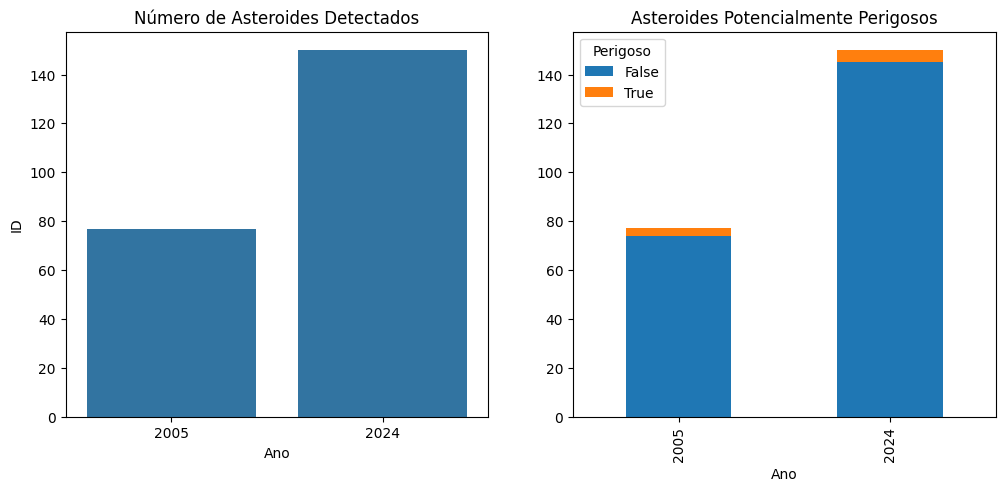

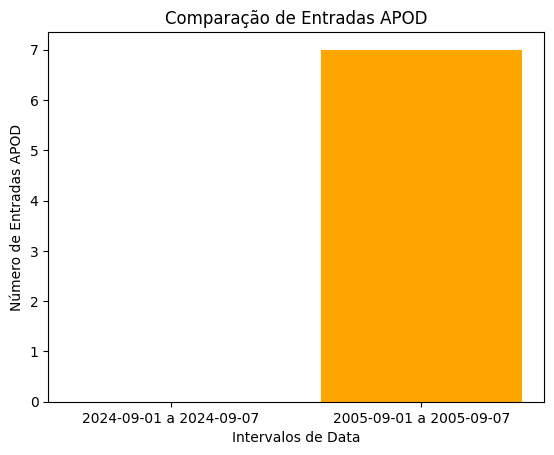

Erro: 429


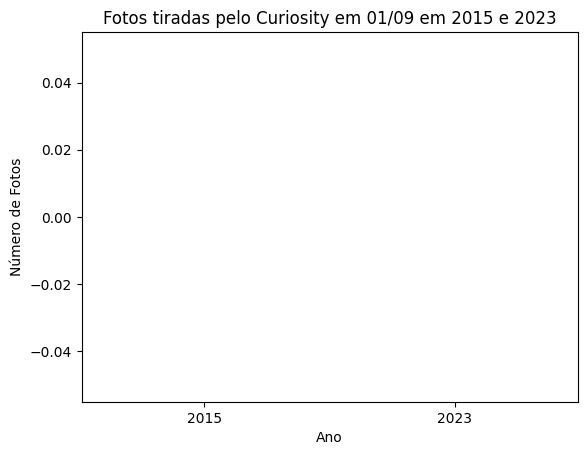

In [18]:
def main() -> None:
    """Função principal que executa a busca e análise de dados da NASA."""
    CHAVE_API = 'dgPFFncGWYee3CsXdymc6IGxwXoTD2bMMbRMgA2d'
    coletor = NASAColetorDados(chave_api=CHAVE_API)
    
    # Define os intervalos de datas para busca
    intervalos_datas = [('2024-09-01', '2024-09-07'), ('2005-09-01', '2005-09-07')]

    # Busca os dados de asteroides para os anos especificados
    dados_asteroides_2024 = pd.DataFrame(coletor.buscar_dados_asteroides(*intervalos_datas[0]))
    dados_asteroides_2005 = pd.DataFrame(coletor.buscar_dados_asteroides(*intervalos_datas[1]))

    # Busca os dados APOD para os anos especificados
    apod_data = [coletor.buscar_imagem_dia(*datas) for datas in intervalos_datas]

    # Cria o analisador de dados
    analisador = AnalisadorDados(coletor, dados_asteroides_2005, dados_asteroides_2024, apod_data)

    # Exibe os detalhes das imagens do dia
    analisador.exibir_imagemdia_detalhes()

    # Plota os gráficos
    analisador.plotar_dados_asteroides()
    analisador.plotar_apod()
    analisador.plotar_fotos_mars_rover('01', '09')

# Executando a função principal
main()